In [4]:
import tensorflow as tf
import numpy as np
import stochastic_I as si
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
#Initialize an interactive session
sess = tf.InteractiveSession()

In [8]:
#some utilities for variable creation
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [5]:
#load in MNIST data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
train_data = mnist.train
validation_data = mnist.validation

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [67]:
#Initialize some hyperparameters
D = 784
N = 30
temperature = tf.placeholder(tf.float32,shape=(),name='temperature')
samples_per_x = 3
training_batch_size = 500
validation_batch_size = 1000

In [68]:
#build our simple linear encoding model
x=tf.placeholder(tf.float32, shape=(None,784), name='x') #input
W = weight_variable([D,N])
V = bias_variable([N])
activation = tf.matmul(x,W) + V

In [69]:
#compute I, retrieve samples of r (though they remain unused in this demo)
I, samples = si.I_hat(activation,temperature,samples_per_x)

In [70]:
#test to make sure it runs
sess.run(tf.global_variables_initializer())
I_test, sample_test = sess.run([I,samples],feed_dict={x:np.ones((12,784)),temperature:0.1})
print I_test

0.969495


In [71]:
#define our objective:
train_objective = -I

In [72]:
#validation score
val_objective = I

In [73]:
#training op
train_op=tf.train.GradientDescentOptimizer(0.5).minimize(train_objective)

In [74]:
#Now the training loop, using early stopping and gradually cooling the temperature
#implements early stopping with tolerance 3
sess.run(tf.global_variables_initializer())
tolerance = 3
marks=0
val_results = []
old_info = -10
current_temp = 0.1
for i in range(2000):
    if i % 50 == 0:
        val_batch = mnist.validation.next_batch(validation_batch_size)
        current_info = sess.run([val_objective],feed_dict={
        x:val_batch[0],
        temperature:current_temp
        })
        if current_info < old_info:
            marks +=1
        else:
            marks = 0
        if marks > tolerance:
            break
        old_info = current_info
        print current_info[0]
        val_results.append(current_info[0])
        current_temp *= 0.8
    train_batch = mnist.train.next_batch(training_batch_size)
    _,objective = sess.run([train_op,train_objective],feed_dict={
        x:train_batch[0],
        temperature:current_temp
    })

3.54229
6.2215
6.31663
6.43313
6.3221
6.34928
6.52888
6.32908
6.27544
6.24808
6.29511
6.0901
6.22687
6.18369
5.88035
5.85926


In [39]:
print val_results

[3.0696793, 4.3280029, 4.3301487, 4.5824394, 4.705307, 4.7650833, 4.8680687, 4.8639317, 5.0070248, 4.8091688, 4.9396906, 4.7697763, 5.0147209, 4.9152546, 5.1346264, 4.9289875, 5.0523272, 5.2093468, 4.9178753, 4.9953365, 5.1477108, 5.1640215, 5.1455536, 5.0210695, 5.0379448, 4.8134813, 5.0289116, 5.077158, 5.0453835, 5.0553007, 4.9641018, 4.9461727, 4.9171753, 5.1739159, 5.074276, 5.0856361, 4.9620714, 5.199543, 5.0280848, 5.0702496]


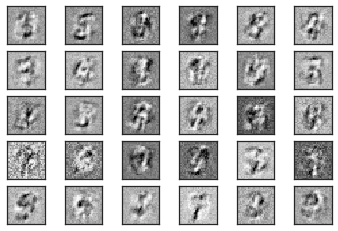

In [76]:
#plot the filters
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

filters = W.eval()

f, axarr = plt.subplots(5, 6)
for j in range(5):
    for k in range(6):
        current_image = np.copy(filters[:,j*6 + k])
        axarr[j,k].imshow(current_image.reshape(28,28),cmap='Greys')
        axarr[j,k].get_xaxis().set_visible(False)
        axarr[j,k].get_yaxis().set_visible(False)
plt.show()